Version de python 3.10.16

1. Set up Super Mario

In [3]:
# Import the game
import gym_super_mario_bros
# Import the joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [4]:
# Setup game
env =  gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [3]:
# 2. Bucle principal de pasos en el entorno
# En la API antigua se esperan 4 valores: observación, recompensa, done, info.

done = True  # Inicializamos la variable 'done'

for step in range(100000):
    # Si el episodio anterior terminó, reiniciamos el entorno
    if done:
        env.reset()
    
    # 3. Ejecutamos un paso en el entorno y obtenemos:
    #    - state: la nueva observación
    #    - reward: la recompensa obtenida
    #    - done: indica si el episodio terminó
    #    - info: diccionario con información extra del paso
    state, reward, done, info = env.step(env.action_space.sample())
    
    # 4. Renderizamos para visualizar lo que ocurre en la pantalla
    env.render()

# 5. Cerramos el entorno al finalizar el bucle
env.close()

c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [5]:
env.close()

2. Preprocess Environment

In [6]:
# Framestack permite 'guardar' varios frames para que el modelo tenga contexto
# GrayScale permite cambiar los colores de la imagen a Blanco y negro
from gym.wrappers import GrayScaleObservation

# Importo los wrappers para poder vectorizar mis datos
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Show the impact of frame stacking
import matplotlib.pyplot as plt

In [7]:
# Crear el environment
env =  gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplificar los controles originales
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Convertir la imagen en escala de grises
env = GrayScaleObservation(env, keep_dim=True)
# Wrap en el env ([dummy
env = DummyVecEnv([lambda: env]) # Se utiliza una funcion lambda, DummyVecEnv recibe funciones e inicializa en entorno cuando lo necesita, se pueden instanciar mas entornos usando mas funciones lambda
# Stackear los frames
env = VecFrameStack(env, 4, channels_order='last')

In [8]:
state = env.reset()

In [9]:
state, reward, done, info = env.step([5])

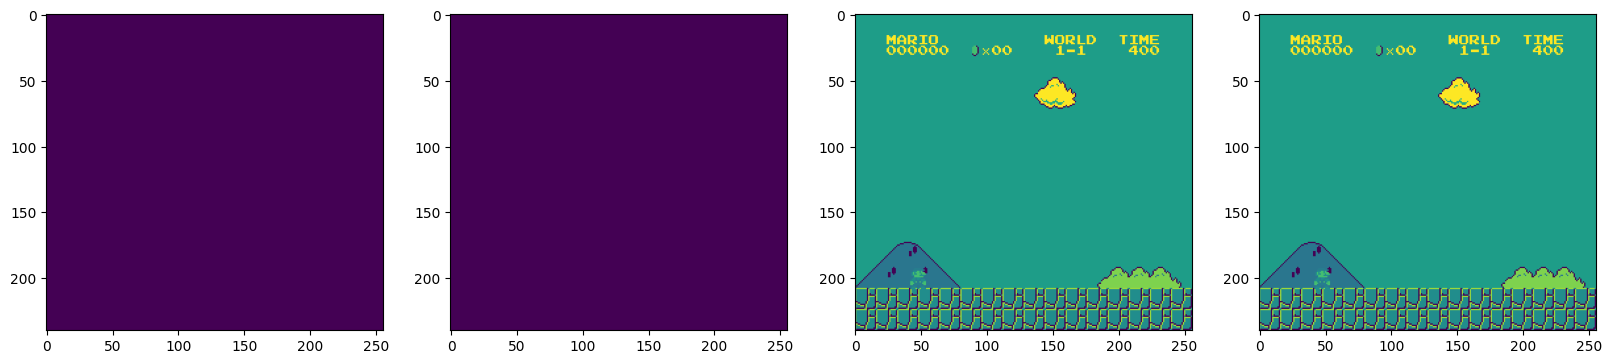

In [10]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

3. Train the RL Model

In [11]:
import os
# Import PPO algorithm
from stable_baselines3 import PPO
# Import base Callb
from stable_baselines3.common.callbacks import BaseCallback

In [11]:
### Clase heredada de BaseCallBack para guardar el modelo segun la frequencia que le indiquemos

# class TrainAndLoggingCallback(BaseCallback):

#     def __init__(self, check_freq, save_path, verbose=1):
#         super(TrainAndLoggingCallback, self).__init__(verbose)
#         self.check_freq = check_freq
#         self.save_path = save_path

#     def _init_callback(self):
#         if self.save_path is not None:
#             os.makedirs(self.save_path, exist_ok=True)

#     def _on_step(self):
#         if self.n_calls % self.check_freq == 0:
#             model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
#             self.model.save(model_path)

#         return True

In [12]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [13]:
### crear el objeto que guarde mi modelo cada 10000 steps en CHECKPOINT_DIR

#callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [13]:
# Inicializacion del modelo con algoritmo PPO de stable_baselines3

model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [15]:
model.learn(total_timesteps=1000000)

Logging to ./logs/PPO_1


c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 251 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 165           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.0112068e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00117      |
|    learning_rate        | 1e-06         |
|    loss                 | 251           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000129     |
|    value_loss           | 586           |
-------------------------------------------
-----

KeyboardInterrupt: 

In [26]:
model.save('../models/modelo')

4. Test it out

In [14]:
model.load('../models/modelo')

c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_

In [15]:
state = env.reset()

while True:

    action, state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render('human')

c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [16]:
env.close()